<a href="https://colab.research.google.com/github/ishara-bangkit-capstone-project/ishara-machine-learning/blob/main/fix/notebooks/binary_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Imort the Necessary Library


In [ ]:
!pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 13.3 MB/s eta 0:00:00


In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from PIL import Image
%matplotlib inline

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# System libraries
from pathlib import Path
import pathlib
import matplotlib.image as mpimg
import zipfile, os, shutil
import seaborn as sn
import datetime

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import flatbuffers
import platform
from tensorflow_lite_support.metadata import metadata_schema_py_generated as _metadata_fb
from tensorflow_lite_support.metadata import schema_py_generated
from tensorflow_lite_support.metadata.python import metadata as _metadata
from tensorflow_lite_support.metadata.python import metadata_writers
import flatbuffers

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load and Transfrom Data

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)

In [ ]:
# Unpacking the the extracting data and putting it in list
data_dir = '/content/gdrive/MyDrive/Binary'

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

# Walk through each directory
walk_through_dir(data_dir)

There are 2 directories and 0 images in '/content/gdrive/MyDrive/Binary'.
There are 0 directories and 130 images in '/content/gdrive/MyDrive/Binary/Hand'.
There are 0 directories and 130 images in '/content/gdrive/MyDrive/Binary/No-Hand'.


In [ ]:
# Create a list to store image paths and labels
images = []
labels = []

# Iterate through each directory and file
for path, subdirs, files in os.walk(data_dir):
    for name in files:
      images.append(os.path.join(path, name))
      labels.append(path.split('/')[-2])

# Change list to DataFrame
df = pd.DataFrame({
    "file_path": images,
    "file_name": [os.path.basename(image) for image in images],
    "label": [os.path.split(os.path.split(image)[0])[1] for image in images]  # Mengambil label dari path
})

# Display some results to verify
print(f"Total images: {len(images)}")
print(f"First 10 image paths: {images[:10]}")
print(f"First 10 labels: {df['label'][:10].tolist()}")


Total images: 260
First 10 image paths: ['/content/gdrive/MyDrive/Binary/Hand/K5.JPG', '/content/gdrive/MyDrive/Binary/Hand/L5.JPG', '/content/gdrive/MyDrive/Binary/Hand/M4.JPG', '/content/gdrive/MyDrive/Binary/Hand/N5.JPG', '/content/gdrive/MyDrive/Binary/Hand/M5.png', '/content/gdrive/MyDrive/Binary/Hand/O1.png', '/content/gdrive/MyDrive/Binary/Hand/J1.jpg', '/content/gdrive/MyDrive/Binary/Hand/J3.jpg', '/content/gdrive/MyDrive/Binary/Hand/J2.jpg', '/content/gdrive/MyDrive/Binary/Hand/K1.jpg']
First 10 labels: ['Hand', 'Hand', 'Hand', 'Hand', 'Hand', 'Hand', 'Hand', 'Hand', 'Hand', 'Hand']


In [ ]:
df.head()

file_path file_name label
0  /content/gdrive/MyDrive/Binary/Hand/K5.JPG    K5.JPG  Hand
1  /content/gdrive/MyDrive/Binary/Hand/L5.JPG    L5.JPG  Hand
2  /content/gdrive/MyDrive/Binary/Hand/M4.JPG    M4.JPG  Hand
3  /content/gdrive/MyDrive/Binary/Hand/N5.JPG    N5.JPG  Hand
4  /content/gdrive/MyDrive/Binary/Hand/M5.png    M5.png  Hand

In [ ]:
# Checking the Distribution of Data from Tag
df.groupby(['label']).size()

label
Hand       130
No-Hand    130
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_path  260 non-null    object
 1   file_name  260 non-null    object
 2   label      260 non-null    object
dtypes: object(3)
memory usage: 6.2+ KB


# Data Preprocessing

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
# Directory for augmented images
augmented_dir = '/content/gdrive/MyDrive/augmented_data'
os.makedirs(augmented_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for index, row in train_df.iterrows():
    img_path = row['file_path']
    label = row['label']

    # Load image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)

    # Create directory for this label if it does not exist
    label_dir = os.path.join(augmented_dir, label)
    os.makedirs(label_dir, exist_ok=True)

    # Generate augmented images and save them
    i = 0
    for batch in augmentor.flow(img_array, batch_size=1, save_to_dir=label_dir, save_prefix='aug', save_format='jpeg'):
        i += 1
        if i >= 5:  # Generate 5 augmented images per original image
            break

# train_df with augmented images
augmented_images = []
for label in os.listdir(augmented_dir):
    label_dir = os.path.join(augmented_dir, label)
    for img_file in os.listdir(label_dir):
        augmented_images.append({'file_path': os.path.join(label_dir, img_file), 'label': label})

augmented_df = pd.DataFrame(augmented_images)

# Concat augmented_df with train_df
train_df = pd.concat([train_df, augmented_df], ignore_index=True)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 978 validated image filenames belonging to 2 classes.
Found 244 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


# Visualizing Images from Dataset

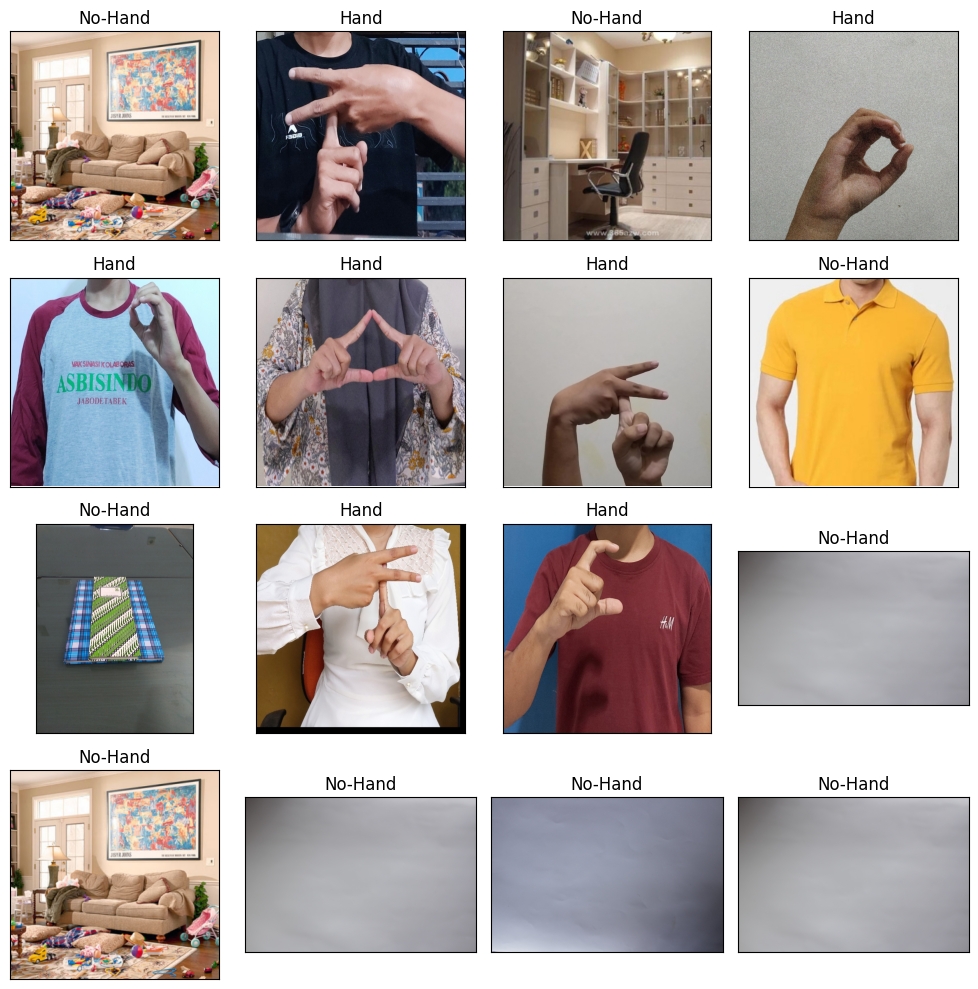

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(df.file_path[random_index[i]])
    ax.imshow(image)
    ax.set_title(df.label[random_index[i]])
plt.tight_layout()
plt.show()


# Training Model

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

pretrained_model.trainable = False

In [ ]:
# Create checkpoint callback
checkpoint_path = "model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

Optimizers = Adam

In [ ]:
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

Functional API

In [ ]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=pretrained_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "bisindo"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/bisindo/20240620-171603
Epoch 1/10
31/31 [==============================] - 79s 2s/step - loss: 0.1764 - accuracy: 0.9387 - val_loss: 0.0342 - val_accuracy: 1.0000
Epoch 2/10
31/31 [==============================] - 56s 2s/step - loss: 0.0211 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 3/10
31/31 [==============================] - 62s 2s/step - loss: 0.0098 - accuracy: 1.0000 - val_loss: 0.0098 - val_accuracy: 1.0000
Epoch 4/10
31/31 [==============================] - 91s 3s/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 5/10
31/31 [==============================] - 68s 2s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0056 - val_accuracy: 1.0000
Epoch 6/10
31/31 [==============================] - 63s 2s/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 1.0000
Epoch 7/10
31/31 [==============================] - 48s 2s/step - loss: 0.0026 - accuracy

In [ ]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.02182
Test Accuracy: 100.00%


In [ ]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

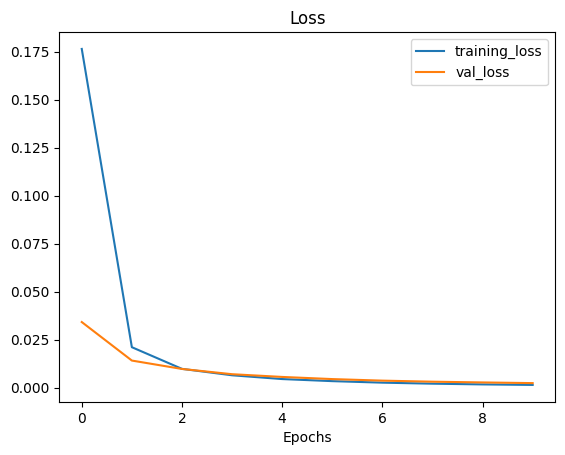

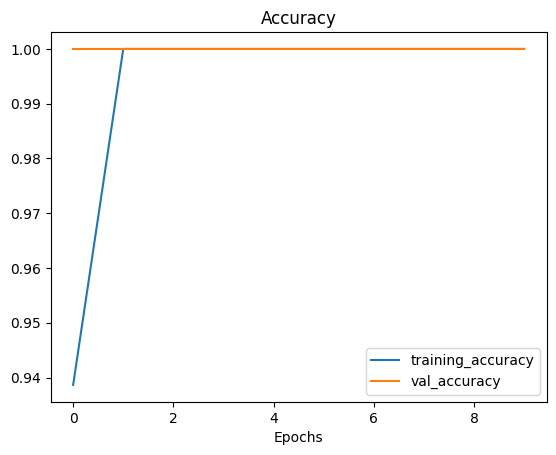

In [ ]:
plot_loss_curves(history)

# Plotting the Classification Reports and Confusion Matrix

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)

# Convert the predicted probabilities to binary labels (0 or 1)
pred = np.where(pred > 0.5, 1, 0)

# Get the true labels
true = test_images.classes

# Print the classification report
print(classification_report(true, pred))

2/2 [==============================] - 3s 489ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        28

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



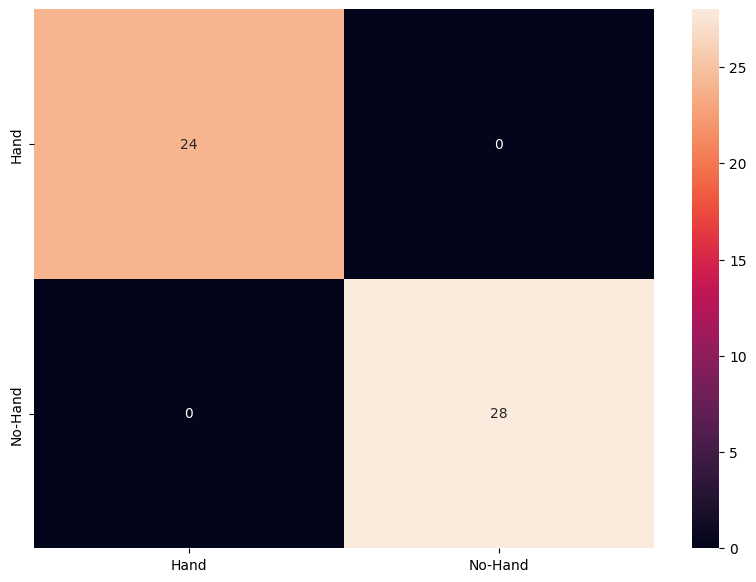

In [ ]:
cfm = confusion_matrix(true, pred)
df_cfm = pd.DataFrame(cfm, index = ["Hand","No-Hand"], columns = ["Hand","No-Hand"])
plt.figure(figsize = (10,7))
cfm_plot = sn.heatmap(df_cfm, annot=True)
cfm_plot.figure.savefig("cfm.png")

2/2 [==============================] - 2s 505ms/step


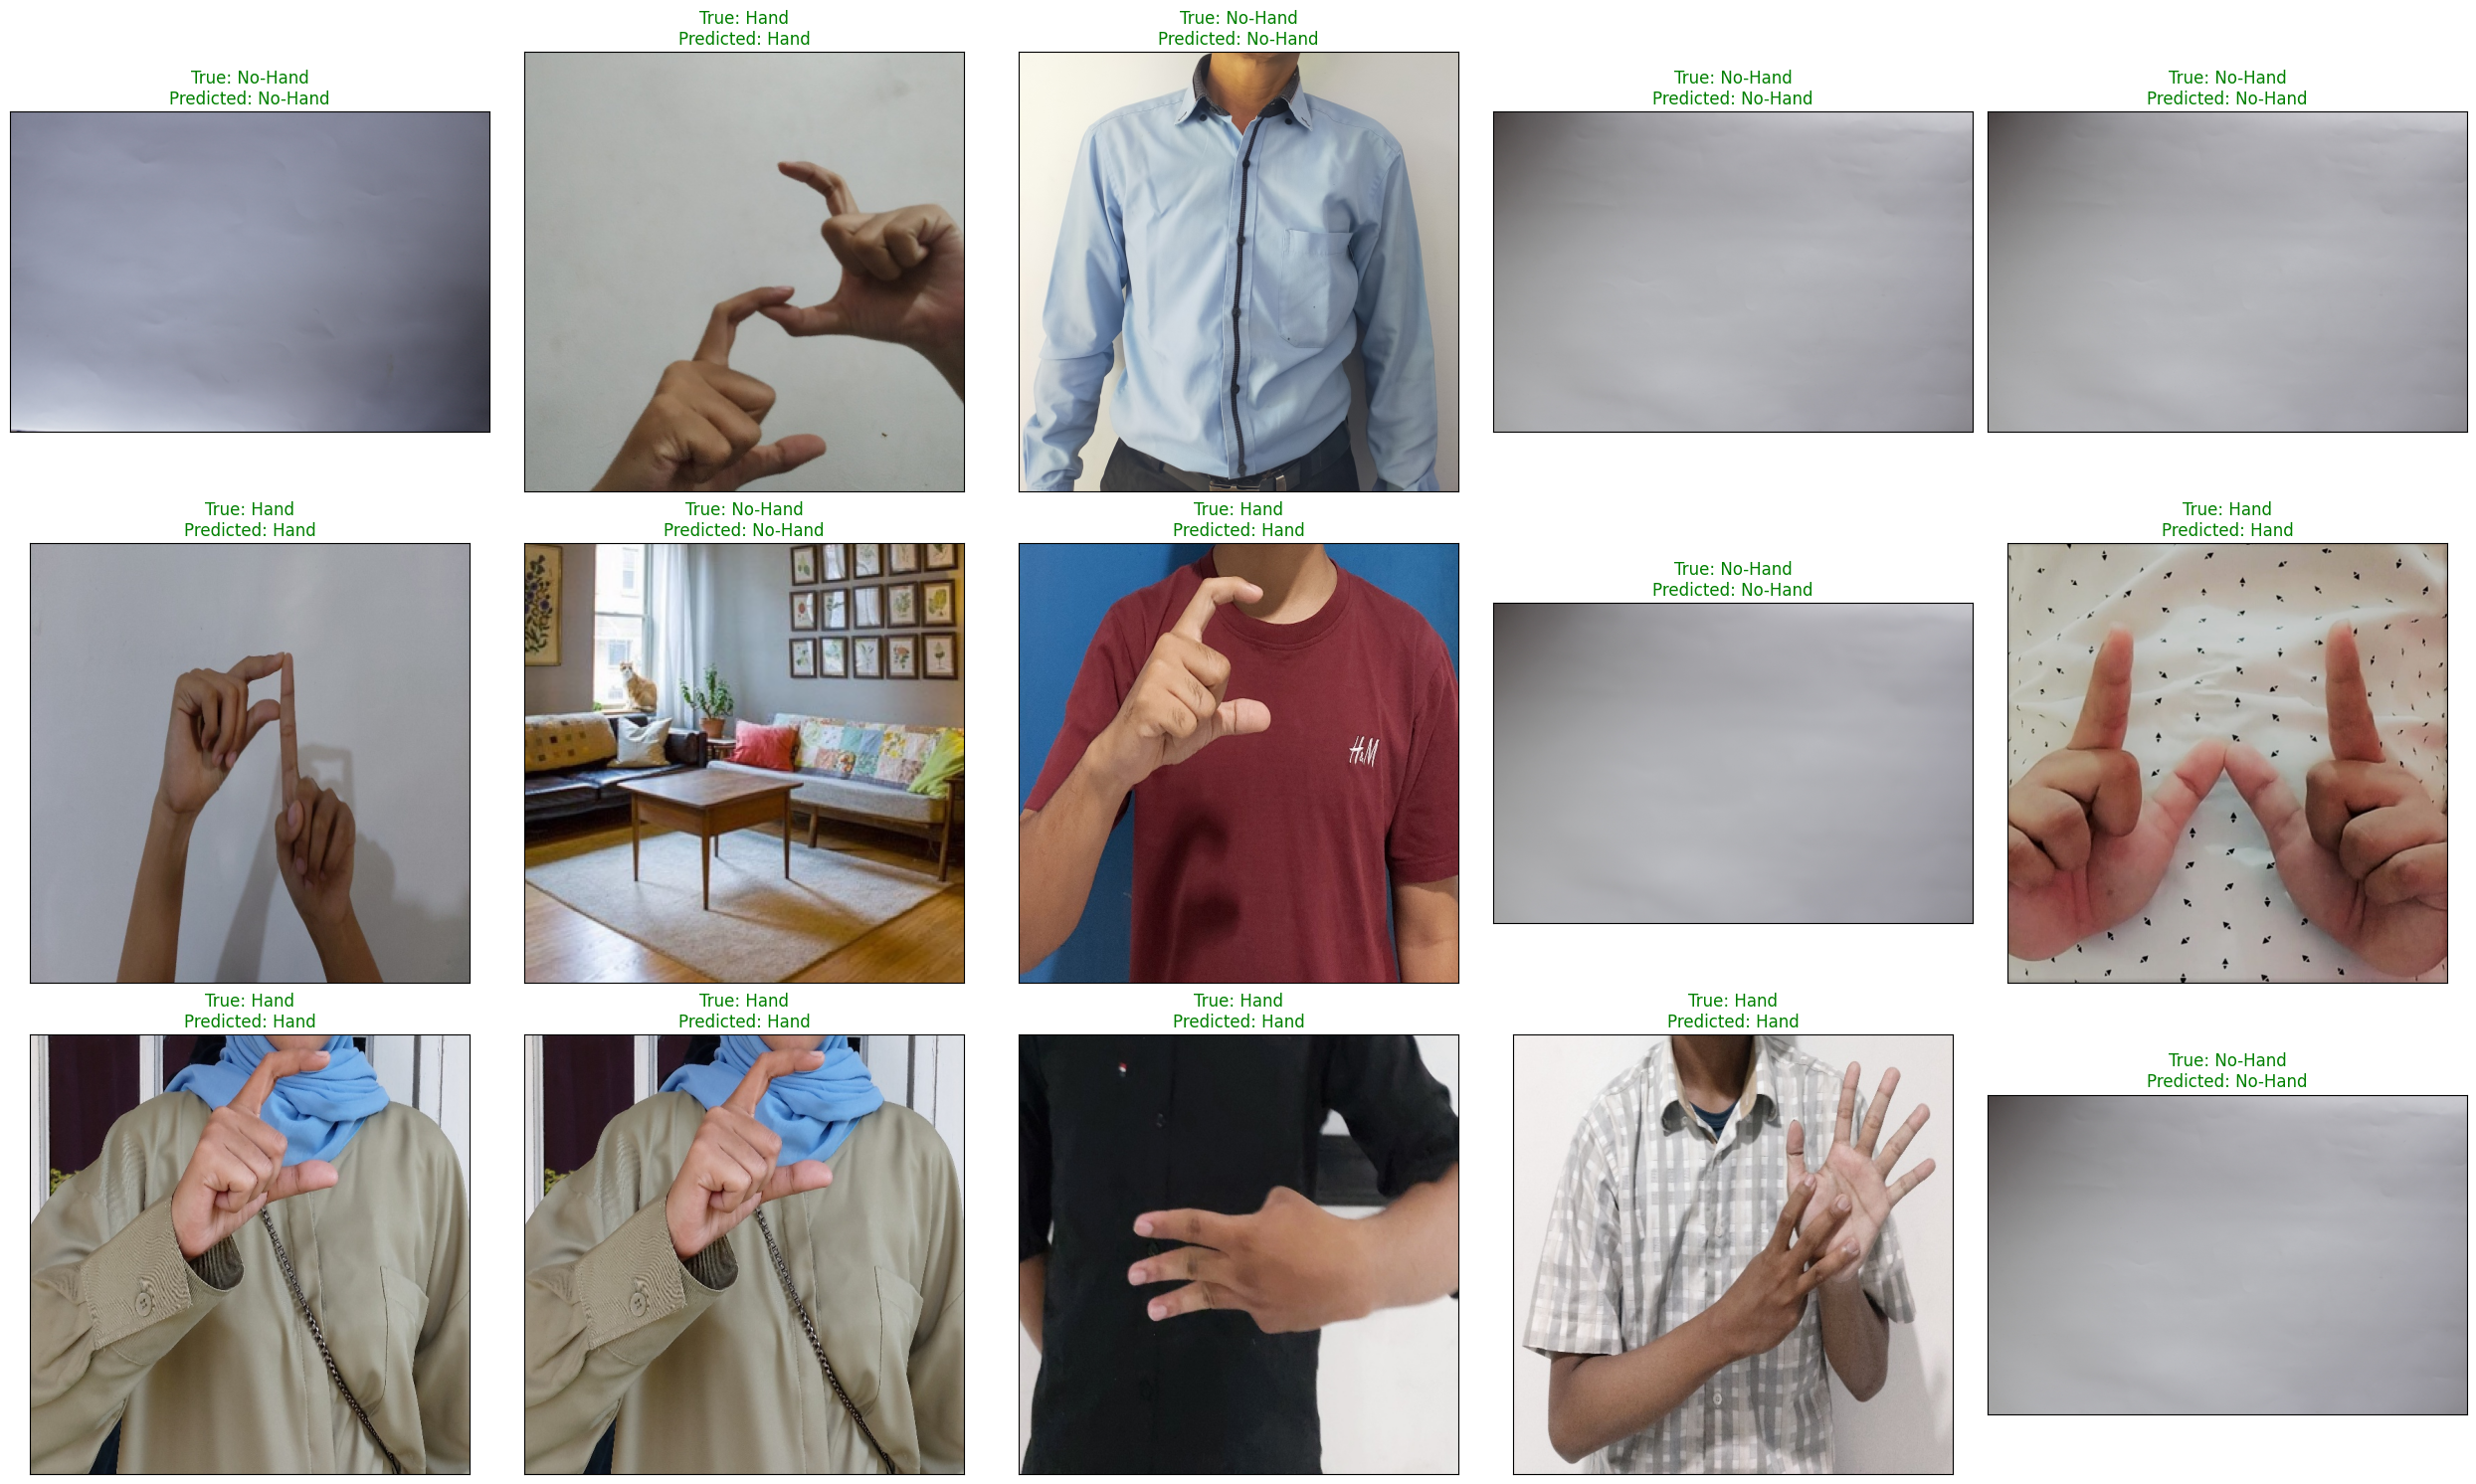

In [ ]:
# Predict the label of the test_images
pred_prob = model.predict(test_images)  # Get probabilities
pred = np.where(pred > 0.5, 1, 0)  # Convert probabilities to binary labels

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred.flatten()]  # Flatten to match the original labels

# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    image = Image.open(test_df.file_path.iloc[random_index[i]])
    ax.imshow(image)
    if test_df.label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.tight_layout()
plt.show()

# Saving Model .h5 and .tflite with Metadata

In [ ]:
model.save('/content/gdrive/MyDrive/ISHARA/savemodels/binary_model.pb')
model.save('/content/gdrive/MyDrive/ISHARA/savemodels/binary_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Use the tf.saved_model API to save the model in the SavedModel format.
export_dir = '/content/gdrive/MyDrive/ISHARA/savemodels'

tf.saved_model.save(model,export_dir=export_dir)

In [ ]:
model.save('/content/gdrive/MyDrive/ISHARA/savemodels/model')

In [ ]:
my_model = tf.keras.models.load_model('/content/gdrive/MyDrive/ISHARA/savemodels/model')

In [ ]:
# Use the TFLiteConverter SavedModel API to initialize the converter
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('/content/gdrive/MyDrive/ISHARA/savemodels/binary_model.tflite')
tflite_model_file.write_bytes(tflite_model)

3816672

In [ ]:
_MODEL_PATH = "/content/gdrive/MyDrive/ISHARA/savemodels/binary_model.tflite"

# Creates model info.
model_meta = _metadata_fb.ModelMetadataT()
model_meta.name = "ISHARA Hand Detection Model"
model_meta.description = ("Hand detection model for identifying hand presence and sign language letters.")
model_meta.version = "v2"
model_meta.author = "C241-PS358"

In [ ]:
# Creates input info.
input_meta = _metadata_fb.TensorMetadataT()

# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()

In [ ]:
input_meta.name = "image"
input_meta.description = (
    "Input image to be classified. The expected image is {0} x {1}, with "
    "three channels (red, blue, and green) per pixel. Each value in the "
    "tensor is a single byte between 0 and 255.".format(224, 224))
input_meta.content = _metadata_fb.ContentT()
input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
input_meta.content.contentProperties.colorSpace = (
    _metadata_fb.ColorSpaceType.RGB)
input_meta.content.contentPropertiesType = (
    _metadata_fb.ContentProperties.ImageProperties)
input_normalization = _metadata_fb.ProcessUnitT()
input_normalization.optionsType = (
    _metadata_fb.ProcessUnitOptions.NormalizationOptions)
input_normalization.options = _metadata_fb.NormalizationOptionsT()
input_normalization.options.mean = [127.5]
input_normalization.options.std = [127.5]
input_meta.processUnits = [input_normalization]
input_stats = _metadata_fb.StatsT()
input_stats.max = [255]
input_stats.min = [0]
input_meta.stats = input_stats

In [ ]:
# Creates output info.
output_meta = _metadata_fb.TensorMetadataT()
output_meta.name = "output"
output_meta.description = "Whether the image contains a hand."
output_meta.content = _metadata_fb.ContentT()
output_meta.content.contentProperties = _metadata_fb.FeaturePropertiesT()
output_meta.content.contentPropertiesType = _metadata_fb.ContentProperties.FeatureProperties

In [ ]:
# Creates subgraph info.
subgraph = _metadata_fb.SubGraphMetadataT()
subgraph.inputTensorMetadata = [input_meta]
subgraph.outputTensorMetadata = [output_meta]
model_meta.subgraphMetadata = [subgraph]

b = flatbuffers.Builder(0)
b.Finish(
    model_meta.Pack(b),
    _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
metadata_buf = b.Output()

In [ ]:
populator = _metadata.MetadataPopulator.with_model_file(_MODEL_PATH)
populator.load_metadata_buffer(metadata_buf)
populator.populate()

In [ ]:
displayer = _metadata.MetadataDisplayer.with_model_file(_MODEL_PATH)
json_file = displayer.get_metadata_json()

print(json_file)

{
  "name": "ISHARA Hand Detection Model",
  "description": "Hand detection model for identifying hand presence and sign language letters.",
  "version": "v2",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified. The expected image is 224 x 224, with three channels (red, blue, and green) per pixel. Each value in the tensor is a single byte between 0 and 255.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
         

In [ ]:
_JSON_OUTPUT_PATH = "/content/gdrive/MyDrive/ISHARA/savemodels/binary_model.json"
# Save the JSON metadata to a file
with open(_JSON_OUTPUT_PATH, 'w') as f:
    f.write(json_file)

print(f"Metadata JSON saved to {_JSON_OUTPUT_PATH}")

Metadata JSON saved to /content/gdrive/MyDrive/ISHARA/savemodels/binary_model.json
